In [1]:
# 노트북 안에서 그래프를 그리기 위해
%matplotlib inline

# Import the standard Python Scientific Libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress Deprecation and Incorrect Usage Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
mcq = pd.read_csv('multipleChoiceResponses.csv',
 encoding="ISO-8859-1", low_memory=False)

## Q6. Do you have recommendation for blog, podcast, class, etc?

In [3]:
mcq['BlogsPodcastsNewslettersSelect'] = mcq[
 'BlogsPodcastsNewslettersSelect'
].astype('str').apply(lambda x: x.split(','))
mcq['BlogsPodcastsNewslettersSelect'].head()

0    [Becoming a Data Scientist Podcast, Data Machi...
1    [Becoming a Data Scientist Podcast, Siraj Rava...
2    [FastML Blog, No Free Hunch Blog, Talking Mach...
3                                     [KDnuggets Blog]
4    [Data Machina Newsletter, Jack's Import AI New...
Name: BlogsPodcastsNewslettersSelect, dtype: object

In [4]:
s = mcq.apply(lambda x: pd.Series(x['BlogsPodcastsNewslettersSelect']),
 axis=1).stack().reset_index(level=1, drop=True)
s.name = 'platforms'
s.head()

0    Becoming a Data Scientist Podcast
0              Data Machina Newsletter
0             O'Reilly Data Newsletter
0         Partially Derivative Podcast
0           R Bloggers Blog Aggregator
Name: platforms, dtype: object

In [5]:
s = s[s != 'nan'].value_counts().head(20)

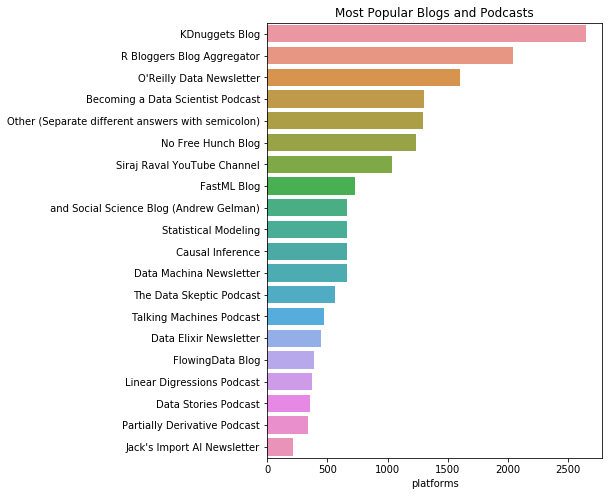

In [6]:
plt.figure(figsize=(6,8))
plt.title("Most Popular Blogs and Podcasts")
sns.barplot(y=s.index, x=s)

In [7]:
mcq['CoursePlatformSelect'] = mcq[
 'CoursePlatformSelect'].astype(
 'str').apply(lambda x: x.split(','))
mcq['CoursePlatformSelect'].head()

0              [nan]
1              [nan]
2    [Coursera, edX]
3              [nan]
4              [nan]
Name: CoursePlatformSelect, dtype: object

In [8]:
t = mcq.apply(lambda x: pd.Series(x['CoursePlatformSelect']),
 axis=1).stack().reset_index(level=1, drop=True)
t.name = 'courses'
t.head(20)

0          nan
1          nan
2     Coursera
2          edX
3          nan
4          nan
5          nan
6          nan
7     Coursera
8          nan
9          nan
10    Coursera
11         nan
12    Coursera
12    DataCamp
12         edX
13         nan
14         nan
15         nan
16         nan
Name: courses, dtype: object

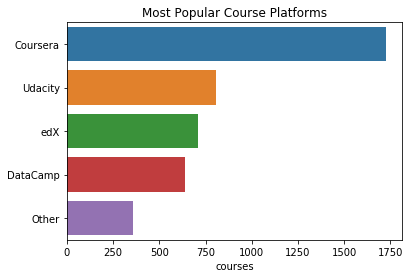

In [9]:
t = t[t != 'nan'].value_counts()
plt.title("Most Popular Course Platforms")
sns.barplot(y=t.index, x=t)

## Q7. What skills do you consider most important in Data Science job?

In [12]:
job_features = [
    x for x in mcq.columns if x.find(
     'JobSkillImportance')!=-1
    and x.find('JobSkillImportanceOther') == -1]

job_features

['JobSkillImportanceBigData',
 'JobSkillImportanceDegree',
 'JobSkillImportanceStats',
 'JobSkillImportanceEnterpriseTools',
 'JobSkillImportancePython',
 'JobSkillImportanceR',
 'JobSkillImportanceSQL',
 'JobSkillImportanceKaggleRanking',
 'JobSkillImportanceMOOC',
 'JobSkillImportanceVisualizations']

In [14]:
jdf = {}
for feature in job_features:
    a = mcq[feature].value_counts()
    a = a/a.sum()
    jdf[feature[len('JobSkillImportance'):]] = a
    
jdf

{'BigData': Nice to have    0.574065
 Necessary       0.379929
 Unnecessary     0.046006
 Name: JobSkillImportanceBigData, dtype: float64,
 'Degree': Nice to have    0.598107
 Necessary       0.279867
 Unnecessary     0.122026
 Name: JobSkillImportanceDegree, dtype: float64,
 'Stats': Necessary       0.513889
 Nice to have    0.457576
 Unnecessary     0.028535
 Name: JobSkillImportanceStats, dtype: float64,
 'EnterpriseTools': Nice to have    0.564970
 Unnecessary     0.290200
 Necessary       0.144829
 Name: JobSkillImportanceEnterpriseTools, dtype: float64,
 'Python': Necessary       0.645994
 Nice to have    0.327214
 Unnecessary     0.026792
 Name: JobSkillImportancePython, dtype: float64,
 'R': Nice to have    0.513945
 Necessary       0.414807
 Unnecessary     0.071247
 Name: JobSkillImportanceR, dtype: float64,
 'SQL': Nice to have    0.491778
 Necessary       0.434224
 Unnecessary     0.073998
 Name: JobSkillImportanceSQL, dtype: float64,
 'KaggleRanking': Nice to have    0.677

In [15]:
jdf = pd.DataFrame(jdf).transpose()
jdf

,Necessary,Nice to have,Unnecessary
BigData,0.379929,0.574065,0.046006
Degree,0.279867,0.598107,0.122026
Stats,0.513889,0.457576,0.028535
EnterpriseTools,0.144829,0.564970,0.290200
Python,0.645994,0.327214,0.026792
R,0.414807,0.513945,0.071247
SQL,0.434224,0.491778,0.073998
KaggleRanking,0.118863,0.677261,0.203876
MOOC,0.107255,0.606994,0.285752
Visualizations,0.455392,0.490820,0.053788


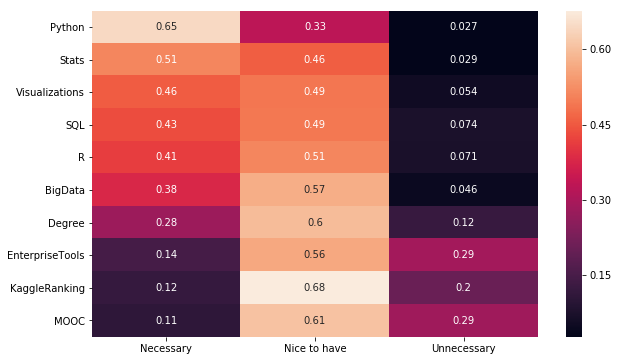

In [16]:
plt.figure(figsize=(10,6))
sns.heatmap(jdf.sort_values("Necessary",
 ascending=False), annot=True)

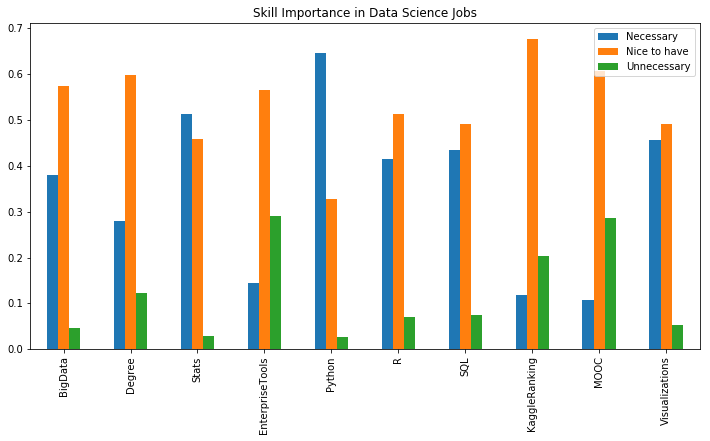

In [17]:
jdf.plot(kind='bar', figsize=(12,6),
 title="Skill Importance in Data Science Jobs")

In [19]:
##Stats...

## Q8. Average salary

In [20]:
mcq[mcq['CompensationAmount'].notnull()].shape

(5224, 228)

In [22]:
#순수한 숫자로 변환
mcq['CompensationAmount'] = mcq[
 'CompensationAmount'].str.replace(',','')
mcq['CompensationAmount'] = mcq[
 'CompensationAmount'].str.replace('-','')

# 환율계산을 위한 정보 가져오기
rates = pd.read_csv('conversionRates.csv')
rates.drop('Unnamed: 0',axis=1,inplace=True)

salary = mcq[
 ['CompensationAmount','CompensationCurrency',
 'GenderSelect',
 'Country',
 'CurrentJobTitleSelect']].dropna()
salary = salary.merge(rates,left_on='CompensationCurrency',
 right_on='originCountry', how='left')
salary['Salary'] = pd.to_numeric(
 salary['CompensationAmount']) * salary['exchangeRate']
salary.head()

,CompensationAmount,CompensationCurrency,GenderSelect,Country,CurrentJobTitleSelect,originCountry,exchangeRate,Salary
0,250000,USD,Male,United States,Operations Research Practitioner,USD,1.000000,250000.0
1,80000,AUD,Female,Australia,Business Analyst,AUD,0.802310,64184.8
2,1200000,RUB,Male,Russia,Software Developer/Software Engineer,RUB,0.017402,20882.4
3,95000,INR,Male,India,Data Scientist,INR,0.015620,1483.9
4,1100000,TWD,Male,Taiwan,Software Developer/Software Engineer,TWD,0.033304,36634.4


In [23]:
print('Maximum Salary is USD $',
 salary['Salary'].dropna().astype(int).max())
print('Minimum Salary is USD $',
 salary['Salary'].dropna().astype(int).min())
print('Median Salary is USD $',
 salary['Salary'].dropna().astype(int).median())

Maximum Salary is USD $ 208999999
Minimum Salary is USD $ -2147483648
Median Salary is USD $ 53812.0


Text(0.5, 1.0, 'Salary Distribution')

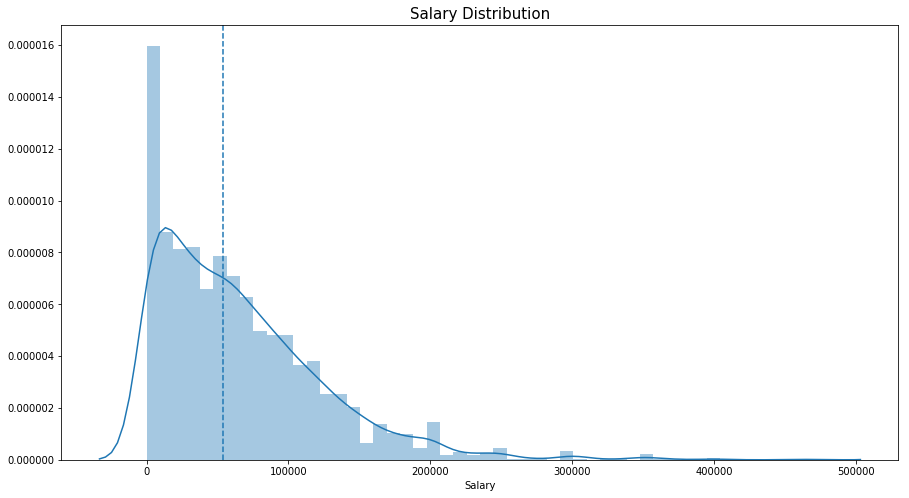

In [34]:
plt.subplots(figsize=(15,8))
salary=salary[salary['Salary']<500000]
sns.distplot(salary['Salary'])
plt.axvline(salary['Salary'].median(), linestyle='dashed')
plt.title('Salary Distribution',size=15)

Text(0.5, 1.0, 'Highest Salary Paying Countries')

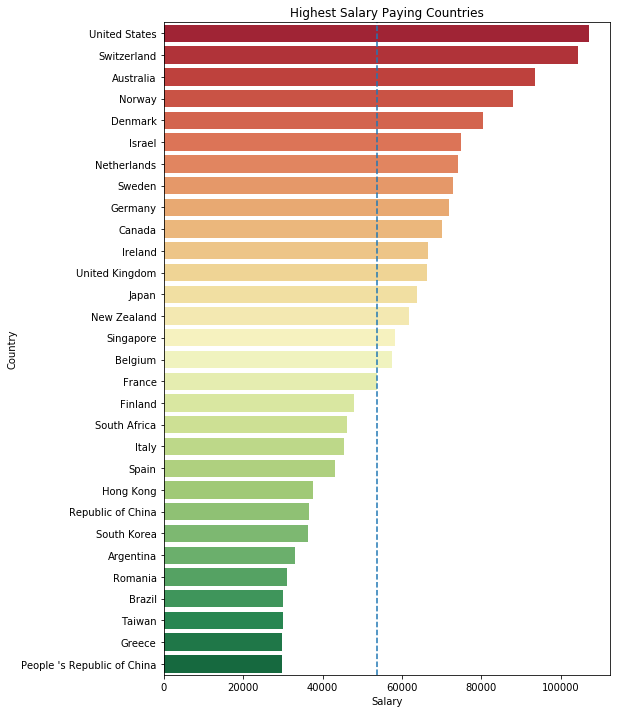

In [35]:
plt.subplots(figsize=(8,12))

sal_coun = salary.groupby(
 'Country')['Salary'].median().sort_values(
 ascending=False)[:30].to_frame()

sns.barplot('Salary',
 sal_coun.index,
 data = sal_coun,
 palette='RdYlGn')

plt.axvline(salary['Salary'].median(), linestyle='dashed')
plt.title('Highest Salary Paying Countries')

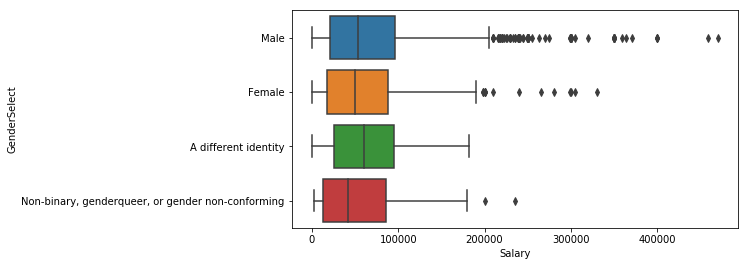

In [36]:
plt.subplots(figsize=(8,4))
sns.boxplot(y='GenderSelect',x='Salary', data=salary)

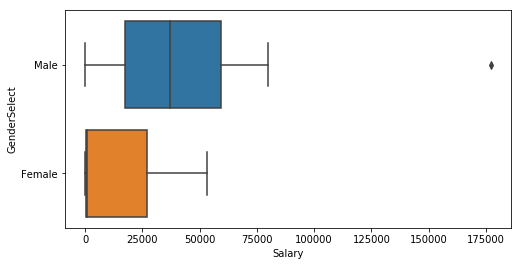

In [38]:
salary_korea = salary.loc[(salary['Country']=='South Korea')]
plt.subplots(figsize=(8,4))
sns.boxplot(y='GenderSelect', x='Salary', data=salary_korea)

In [39]:
salary_korea.shape

(26, 8)

In [40]:
salary_korea[salary_korea['GenderSelect'] == 'Female']

,CompensationAmount,CompensationCurrency,GenderSelect,Country,CurrentJobTitleSelect,originCountry,exchangeRate,Salary
479,30000,KRW,Female,South Korea,Data Analyst,KRW,0.000886,26.58
2903,800000,KRW,Female,South Korea,Researcher,KRW,0.000886,708.80
4063,60000000,KRW,Female,South Korea,Researcher,KRW,0.000886,53160.00


In [41]:
salary_korea_male = salary_korea[
 salary_korea['GenderSelect']== 'Male']
salary_korea_male['Salary'].describe()

count        23.000000
mean      43540.617217
std       37800.608484
min           0.886000
25%       17500.000000
50%       37212.000000
75%       59238.000000
max      177200.000000
Name: Salary, dtype: float64

In [42]:
salary_korea_male

,CompensationAmount,CompensationCurrency,GenderSelect,Country,CurrentJobTitleSelect,originCountry,exchangeRate,Salary
85,40000000,KRW,Male,South Korea,Business Analyst,KRW,0.000886,35440.000
147,80000,USD,Male,South Korea,Researcher,USD,1.000000,80000.000
314,60000,USD,Male,South Korea,Business Analyst,USD,1.000000,60000.000
333,60000000,KRW,Male,South Korea,Researcher,KRW,0.000886,53160.000
562,50000000,KRW,Male,South Korea,Researcher,KRW,0.000886,44300.000
769,42000000,KRW,Male,South Korea,Software Developer/Software Engineer,KRW,0.000886,37212.000
799,1000,KRW,Male,South Korea,Machine Learning Engineer,KRW,0.000886,0.886
1060,75000000,KRW,Male,South Korea,Scientist/Researcher,KRW,0.000886,66450.000
1360,30000000,KRW,Male,South Korea,Statistician,KRW,0.000886,26580.000
1568,90000,SGD,Male,South Korea,Computer Scientist,SGD,0.742589,66833.010


## Q9. Where do you get the data for private project or learning?

In [43]:
mcq['PublicDatasetsSelect'] = mcq[
 'PublicDatasetsSelect'].astype('str').apply(
 lambda x: x.split(',')
 )

In [44]:
q = mcq.apply(
 lambda x: pd.Series(x['PublicDatasetsSelect']),
 axis=1).stack().reset_index(level=1, drop=True)

q.name = 'courses'

In [45]:
q = q[q != 'nan'].value_counts()
pd.DataFrame(q)

,courses
Dataset aggregator/platform (i.e. Socrata/Kaggle Datasets/data.world/etc.),6843
Google Search,3600
University/Non-profit research group websites,2873
I collect my own data (e.g. web-scraping),2560
GitHub,2400
Government website,2079
Other,399


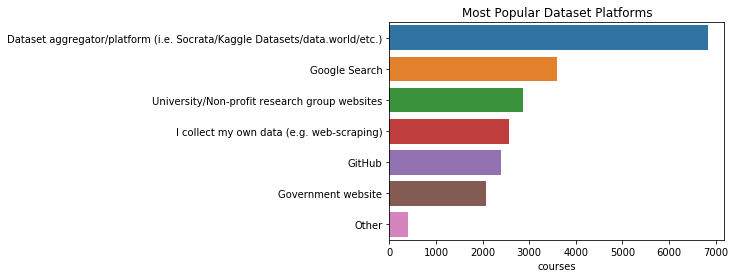

In [46]:
plt.title("Most Popular Dataset Platforms")
sns.barplot(y=q.index, x=q)

In [48]:
# 주관식 응답을 읽어온다.
ff = pd.read_csv('freeformResponses.csv',
 encoding="ISO-8859-1", low_memory=False)
ff.shape

(16716, 62)

In [54]:
question = pd.read_csv('schema.csv')
qc = question.loc[question[
 'Column'].str.contains('PersonalProjectsChallengeFreeForm')]
print(qc.shape)
qc.Question.values[0]

(1, 3)


'What is your biggest challenge with the public datasets you find for personal projects?'

In [55]:
ppcff = ff[
 'PersonalProjectsChallengeFreeForm'].value_counts().head(15)
ppcff.name = '응답 수'
pd.DataFrame(ppcff)

,응답 수
None,23
Cleaning,20
Cleaning the data,20
Dirty data,16
Data Cleaning,14
none,13
Data cleaning,10
dirty data,10
Size,9
-,9
